In [102]:
import pandas as pd

# TODO: update for state
STATE = 'ma'
YEARS = [str(yr) for yr in range(2011, 2021)]

In [103]:
"""
File naming convension for ACS 5-year downloads:
state_year_[race|income].csv

"""

def get_filepath(state):
    return '../data/{state}/'.format(state=state)

def get_fname(state, year, dataset_type):
    return '{state}_{year}_{dataset_type}.csv'.format(
        state=state, year=year, dataset_type=dataset_type)

def get_filename(state, year, dataset_type):
    return get_filepath(state) + get_fname(state, year, dataset_type)


# geoid is the column we join data on
geoid_column_name = 'geoid'

geoid_column_map = {
    'GEO.id2': geoid_column_name,
    'GEO_ID': geoid_column_name
}

# for some reason particular file(s) have different column names- WHY?!
filename_income_column_map = {
    'ma_2017_income.csv': {
        'HC03_EST_VC02': 'median income',
        'HC03_MOE_VC02': 'median income margin of error',
        'HD01_VD01': 'median income',
        'HD02_VD01': 'median income margin of error'
    }
}
# Here is the default
income_column_map = {
    'HC02_EST_VC02': 'median income',
    'HC02_MOE_VC02': 'median income margin of error',
    'HD01_VD01': 'median income',
    'HD02_VD01': 'median income margin of error'
}

new_income_map = {
    'S1903_C03_001E': 'median income',
    'S1903_C03_001M': 'median income margin of error'
}

race_column_map = {
    'HD01_VD01': 'race: total households',
    'HD02_VD01': 'race: total households margin of error',
    'HD01_VD02': 'race: White',
    'HD01_VD03': 'race: Black',
    'HD01_VD05': 'race: Asian',
    'HD01_VD08': 'race: 2 or more races',
    # The following are combined into one value
    # 'HD01_VD04': 'race: American Indian and Alaska',
    # 'HD01_VD06': 'race: Native Hawaiian and Other',
    'HD01_VD07': 'race: Other',
}

new_race_column_map = {
    'B02001_001E': 'race: total households',
    'B02001_001M': 'race: total households margin of error',
    'B02001_002E': 'race: White',
    'B02001_003E': 'race: Black',
    'B02001_005E': 'race: Asian',
    'B02001_008E': 'race: 2 or more races',
    'B02001_007E': 'race: Other'
}

def race_combine_other(row):
    
    """Combines the values for the other races with american indian, hawaiian, etc"""
    try:
        return int(row['HD01_VD04']) + int(row['HD01_VD06']) + int(row['HD01_VD07'])
    except:
        return int(row['B02001_004E']) + int(row['B02001_006E']) + int(row['B02001_007E'])

def col_name_for_year(year, col_name):
    return str(year) + ' ' + col_name

def remove_labels(df):
    # drop the first row (the first row is a display label)
    df.drop([0], inplace=True)

def preprocess_df(df, year, column_map):
    # prune data
    #data from 2018-onwards only has GEO_ID not GEO.id2
    if int(year) > 2017:
        for num in range(1, df.shape[0]+1):
            df.at[num, 'GEO_ID'] = df.at[num, 'GEO_ID'][-11:]
        
    # rename columns
    column_name_map = {key: col_name_for_year(year, value) for key, value in column_map.items()}
    print(column_name_map)
    column_name_map.update(geoid_column_map)
    cols_to_drop = [col for col in df.columns if not col in column_name_map.keys()]

    df.drop(cols_to_drop,  axis=1,  inplace=True)
    df.rename(columns=column_name_map, inplace=True)
    df.set_index(geoid_column_name, inplace=True)
    return df


def get_race_df(state, year):
    filename = get_filename(STATE, year, 'race')
    df = pd.read_csv(filename)
    remove_labels(df)
    if int(year) < 2018:
        column = 'HD01_VD07'
    else:
        column = 'B02001_007E'
    df['column'] = df.apply(race_combine_other, axis=1)
    if int(year) > 2017:
        map = new_race_column_map
    else:
        map = race_column_map
    return preprocess_df(df, year, map)


def get_income_df(state, year):
    # so annoying that the columns change with files!
    if int(year) > 2017:
        map = new_income_map
    else:
        map = income_column_map
    fname = get_fname(state, year, 'income')
    print('filename', fname)
    if fname in filename_income_column_map:
        map = filename_income_column_map[fname]
    df = pd.read_csv(get_filename(STATE, year, 'income'))
    remove_labels(df)
    return preprocess_df(df, year, map)


In [104]:
# We merge data into the income df

def add_df(df1, df2):
    # comebine the df's on geoid
    return pd.concat([df1, df2], axis=1, join='inner')

state_df = None
for year in YEARS:
    print('handling files for year ', year)
    income_df = get_income_df(STATE, year)
    if state_df is None:
        state_df = income_df
    else:
        state_df = add_df(state_df, income_df)
    race_df = get_race_df(STATE, year)
    state_df = add_df(state_df, race_df)

state_df.head()

handling files for year  2011
filename ma_2011_income.csv
{'HC02_EST_VC02': '2011 median income', 'HC02_MOE_VC02': '2011 median income margin of error', 'HD01_VD01': '2011 median income', 'HD02_VD01': '2011 median income margin of error'}
{'HD01_VD01': '2011 race: total households', 'HD02_VD01': '2011 race: total households margin of error', 'HD01_VD02': '2011 race: White', 'HD01_VD03': '2011 race: Black', 'HD01_VD05': '2011 race: Asian', 'HD01_VD08': '2011 race: 2 or more races', 'HD01_VD07': '2011 race: Other'}
handling files for year  2012
filename ma_2012_income.csv
{'HC02_EST_VC02': '2012 median income', 'HC02_MOE_VC02': '2012 median income margin of error', 'HD01_VD01': '2012 median income', 'HD02_VD01': '2012 median income margin of error'}
{'HD01_VD01': '2012 race: total households', 'HD02_VD01': '2012 race: total households margin of error', 'HD01_VD02': '2012 race: White', 'HD01_VD03': '2012 race: Black', 'HD01_VD05': '2012 race: Asian', 'HD01_VD08': '2012 race: 2 or more rac

,2011 median income,2011 median income margin of error,2011 race: total households,2011 race: total households margin of error,2011 race: White,2011 race: Black,2011 race: Asian,2011 race: Other,2011 race: 2 or more races,2012 median income,...,2019 race: 2 or more races,2020 median income,2020 median income margin of error,2020 race: total households,2020 race: total households margin of error,2020 race: White,2020 race: Black,2020 race: Asian,2020 race: Other,2020 race: 2 or more races
geoid,,,,,,,,,,,,,,,,,,,,,
25001010100,46547,3913,2994,13,2787,109,0,0,98,46031,...,119,71495,10373,2972,19,2639,58,69,108,98
25001010206,59234,11997,2858,256,2774,2,0,16,66,54959,...,122,82990,14590,3662,326,3083,93,21,36,429
25001010208,71964,38247,1903,260,1855,0,17,0,0,81964,...,1,68914,31118,1076,324,1036,38,0,1,1
25001010304,69659,23145,2395,269,2335,15,22,0,7,70000,...,26,57353,14035,2495,242,2319,19,141,0,16
25001010306,50357,16558,2616,270,2563,9,44,0,0,51047,...,42,73448,10627,2401,241,2271,0,0,91,11


In [106]:
# Save the giant dataframe to CSV
output_csvfilename = get_filepath(STATE) + 'race_and_income_data.csv'
state_df.to_csv(output_csvfilename)
print('saved data to ',  output_csvfilename)

saved data to  ../data/ma/race_and_income_data.csv


In [107]:
import geopandas as gpd

In [108]:
"""Creates shapefile from NYC open data download.
This shapefile does not have geoids, so must add them based on its other data.

"""

NY_STATE_CODE = '36'

nyc_shapefile_attributes = {
    geoid_column_name: geoid_column_name,
    'ntaname': 'Name', # name of neighborhood in this dataset
    # Tracts are duplicated across boros.
    # The unique key is 'boro_ct201' which is the concatenation of boro id and ct
    # 'ct2010': 'tract',
    'shape_area': 'shape_area',
    'shape_leng': 'shape_leng',
    'geometry': 'geometry'
}
ma_shapefile_attributes = {
    'GEOID10': geoid_column_name,
    'NAMELSAD10': 'Name', # 'Census Tract ###'  in this dataset
    'SHAPE_AREA': 'shape_area',
    'SHAPE_LEN': 'shape_leng',
    'geometry': 'geometry'
}

# Mapping of boro names to county code for geoid
# Taken from wikipedia info: https://en.wikipedia.org/wiki/List_of_counties_in_New_York
nyc_boro_to_county_code = {
    'Bronx':'005',
    'Queens':'081',
    'Brooklyn':'047',
    'Manhattan':'061',
    'Staten Island':'085'
}


def get_nyc_shapefile():
    shapefile_filename = get_filepath('ny') + 'city_census_tracts_shapefile/geo_export_6f3df1e4-1be2-4395-ba6c-3e15b0a10221.shp'
    shapefile_df = gpd.read_file(shapefile_filename)
    shapefile_df[geoid_column_name] = shapefile_df.apply(get_nyc_geoid, axis=1)
    return shapefile_df


def get_nyc_county_code(row):
    boro_name = row['boro_name']
    return nyc_boro_to_county_code[boro_name]


def get_nyc_geoid(row):
    state_code = NY_STATE_CODE
    county_code = get_nyc_county_code(row)
    tract_code = row['ct2010']
    return str(state_code) + str(county_code) + str(tract_code)

shapefile_df = None
if STATE == 'ny':
    shapefile_df = get_nyc_shapefile()
    shapefile_attributes = nyc_shapefile_attributes
elif STATE == 'ma':
    shapefile_filename = get_filepath(STATE) + 'shapefile/boston-brookline-cambridge-somerville-everett.shp'
    shapefile_df = gpd.read_file(shapefile_filename)
    shapefile_attributes = ma_shapefile_attributes

shapefile_df.head()

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,ALAND10,AWATER10,INTPTLAT10,...,AREA_ACRES,POP100_RE,HU100_RE,LOGPL94171,LOGSF1,LOGACS0610,LOGSF1C,SHAPE_AREA,SHAPE_LEN,geometry
0,25,021,401200,25021401200,4012,Census Tract 4012,G5020,6692464.0,32335.0,+42.3146076,...,1661.6151,7031,2645,0141546,123438,0003622,0123438,6.724345e+06,11423.687064,"POLYGON ((230135.432 895483.029, 230125.954 89..."
1,25,021,401100,25021401100,4011,Census Tract 4011,G5020,4116857.0,109099.0,+42.3238531,...,1044.1827,4441,1629,0141542,123434,0003621,0123434,4.225675e+06,11885.022027,"POLYGON ((230635.043 897756.710, 230632.614 89..."
2,25,021,401000,25021401000,4010,Census Tract 4010,G5020,640097.0,580.0,+42.3274299,...,158.3029,3149,1342,0141538,123430,0003620,0123430,6.406316e+05,3428.999786,"POLYGON ((231725.302 897626.698, 231722.282 89..."
3,25,021,400900,25021400900,4009,Census Tract 4009,G5020,383245.0,2025.0,+42.3332089,...,95.1955,3865,2017,0141534,123426,0003619,0123426,3.852440e+05,2872.982317,"POLYGON ((232018.183 898306.152, 232011.209 89..."
4,25,021,400800,25021400800,4008,Census Tract 4008,G5020,567433.0,5033.0,+42.3387738,...,141.4504,5630,2636,0141530,123422,0003618,0123422,5.724317e+05,3649.975331,"POLYGON ((231517.074 899012.450, 231587.350 89..."


In [109]:
# Map column names and remove columns
shapefile_cols_to_drop = [col for col in shapefile_df.columns if not col in shapefile_attributes.keys()]
shapefile_df.drop(shapefile_cols_to_drop,  axis=1,  inplace=True)
shapefile_df.rename(columns=shapefile_attributes, inplace=True)
shapefile_df.set_index(geoid_column_name, inplace=True)
shapefile_df.head()

,Name,shape_area,shape_leng,geometry
geoid,,,,
25021401200,Census Tract 4012,6.724345e+06,11423.687064,"POLYGON ((230135.432 895483.029, 230125.954 89..."
25021401100,Census Tract 4011,4.225675e+06,11885.022027,"POLYGON ((230635.043 897756.710, 230632.614 89..."
25021401000,Census Tract 4010,6.406316e+05,3428.999786,"POLYGON ((231725.302 897626.698, 231722.282 89..."
25021400900,Census Tract 4009,3.852440e+05,2872.982317,"POLYGON ((232018.183 898306.152, 232011.209 89..."
25021400800,Census Tract 4008,5.724317e+05,3649.975331,"POLYGON ((231517.074 899012.450, 231587.350 89..."


c:\Users\Walter\anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot:>

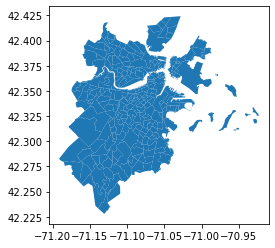

In [110]:
# Want projection CRS84 which is equivalent to EPSG:4326
shapefile_df = shapefile_df.to_crs({'init': 'epsg:4326'})

%matplotlib inline
shapefile_df.plot()

In [111]:
merged_shapes = shapefile_df.merge(state_df, on=geoid_column_name)
print('shape', merged_shapes.shape)
merged_shapes.head()

shape (215, 94)


,Name,shape_area,shape_leng,geometry,2011 median income,2011 median income margin of error,2011 race: total households,2011 race: total households margin of error,2011 race: White,2011 race: Black,...,2019 race: 2 or more races,2020 median income,2020 median income margin of error,2020 race: total households,2020 race: total households margin of error,2020 race: White,2020 race: Black,2020 race: Asian,2020 race: Other,2020 race: 2 or more races
geoid,,,,,,,,,,,,,,,,,,,,,
25021401100,Census Tract 4011,4.225675e+06,11885.022027,"POLYGON ((-71.12830 42.32970, -71.12833 42.329...",161333,42691,4474,354,3751,34,...,256,211375,53099,4097,586,3048,104,647,37,261
25021401000,Census Tract 4010,6.406316e+05,3428.999786,"POLYGON ((-71.11508 42.32849, -71.11512 42.328...",84318,30474,3028,263,2305,87,...,377,130887,30147,3183,366,2176,110,512,19,358
25021400900,Census Tract 4009,3.852440e+05,2872.982317,"POLYGON ((-71.11149 42.33459, -71.11157 42.334...",71417,20311,3871,386,2646,194,...,59,87656,22897,3933,422,2661,286,762,63,143
25021400800,Census Tract 4008,5.724317e+05,3649.975331,"POLYGON ((-71.11753 42.34097, -71.11668 42.340...",65192,23920,5396,459,4007,91,...,152,91205,17651,5507,581,4247,65,735,0,460
25021400700,Census Tract 4007,6.062395e+05,3356.400056,"POLYGON ((-71.12052 42.33597, -71.12002 42.335...",135481,19582,3827,375,2920,125,...,141,140966,33593,3264,438,2679,57,379,34,115


In [112]:
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

In [113]:
to_filename = get_filepath(STATE) + STATE  + '_census_tracts.geojson'
print('saving to ',to_filename)
merged_shapes["geometry"] = [MultiPolygon([feature]) if type(feature) == Polygon \
    else feature for feature in merged_shapes["geometry"]]
merged_shapes.to_file(to_filename, driver='GeoJSON')
print('saved')
sort = False

saving to  ../data/ma/ma_census_tracts.geojson
saved


In [ ]:
print('testing')

testing
